# Setup

### 1. Install required libraries

In [1]:
# BiocManager::install("philr")
# BiocManager::install("phyloseq")
# BiocManager::install("microbiome")
# install.packages("RColorBrewer")
# install.packages("UpSetR")
# install.packages("ggfortify")
# install.packages("randomForest")
# install.packages("rfUtilities")
# install.packages("phytools")
# install.packages("gridExtra")
# install.packages("remotes")
# install.packages('devtools')
# install.packages("intergraph")
# devtools::install_github('reptalex/phylofactor')
# devtools::install_github("briatte/ggnet")
# remotes::install_github("vmikk/metagMisc")
# remotes::install_github("pmartinezarbizu/pairwiseAdonis/pairwiseAdonis")
# remotes::install_github("gauravsk/ranacapa")

Skipping install of 'ranacapa' from a github remote, the SHA1 (58c0cabb) has not changed since last install.
  Use `force = TRUE` to force installation



### 2. Load required libraries

In [31]:
library(philr)
library(RColorBrewer)
library(UpSetR)
library(ggfortify)
library(randomForest)
library(rfUtilities)
library(phytools)
library(phyloseq)
library(gridExtra)
library(microbiome)
library(phylofactor)
library(dplyr)
library(pairwiseAdonis)
library(ape)
library(metagMisc)
library(ranacapa)
library(MASS)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




### 3. Load data into R

In [56]:
map <- read.table("map.txt", sep="\t", header=T, row.names=1)
# seqtab <- read.table("../01-read_processing/sequence_table.merged.txt", header=T, row.names=1)
# tax <- read.table("../01-read_processing/taxonomy_bac.txt", header=F, row.names=1, sep="\t")
# tree <- read.tree("../01-read_processing/rep_set.align.tre")
# tree.root <- midpoint.root(tree)

### 4. Which samples are missing from metadata/sequence table?

In [57]:
# load(".RData") # only can use if full script has already been run
notinmeta <- setdiff(row.names(seqtab), row.names(map))
notinraw <- setdiff(row.names(map), row.names(seqtab))
print("Samples found in ASV table but not in metadata:")
notinmeta
print("Samples found in metadata but not in sequencing table:")
notinraw

[1] "Samples found in ASV table but not in metadata:"


character(0)

[1] "Samples found in metadata but not in sequencing table:"


character(0)

### 5. Create phyloseq object

In [58]:
ps.dat <- phyloseq(otu_table(seqtab, taxa_are_rows=F), sample_data(map), tax_table(as.matrix(tax)), tree.root)
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21801 taxa and 969 samples ]
sample_data() Sample Data:       [ 969 samples by 36 sample variables ]
tax_table()   Taxonomy Table:    [ 21801 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21801 tips and 21800 internal nodes ]

### 6. Filter out low prevalence ASVs

In [ ]:
# compute prevalence dataframe
prevdf <- apply(X=otu_table(ps.dat), MARGIN=ifelse(taxa_are_rows(ps.dat), yes=1, no=2), FUN=function(x){sum(x>0)})
# add taxa and total read counts to dataframe
prevdf <- data.frame(Prevalence=prevdf, TotalAbundance=taxa_sums(ps.dat), tax_table(ps.dat))
# which phyla are comprised as mostly low prevalence ASVs?
lowprev <- ggplot(prevdf, aes(TotalAbundance, Prevalence, nsamples(ps.dat), color="V4")) + geom_hline(yintercept=0.05, alpha=0.5, linetype=2) + geom_point(size=2, alpha=0.7) + scale_x_log10() + xlab("Total Abundance") + ylab("Prevalence [Frac. Samples]") + facet_wrap(~V4) + theme(legend.position="none")
lowprev
pdf("totalabund_vs_prevalence.pdf")
lowprev
dev.off()
# kept asvs must be found in at least 1% of all samples 
ps.dat <- phyloseq_filter_prevalence(ps.dat, prev.trh=0.01)
ps.dat

pdf 
  2

### 7. Remove samples with fewer than 4000 reads post filtering, remove control samples

In [ ]:
ps.dat <- prune_samples(sample_sums(ps.dat) > 4000, ps.dat)
ps.dat <- subset_samples(ps.dat, study_group != "mock")
ps.dat
# save image
save.image()

### 8. Write filtered ASV, metadata, and taxonomy table to file

In [8]:
write.table(as.data.frame(otu_table(ps.dat)), "../01-read_processing/sequence_table.filt.txt", sep="\t", row.names=T, col.names=T)
# write filtered taxonomy to file
write.table(as.data.frame(tax_table(ps.dat)), "../01-read_processing/taxonomy_bac.filt.txt", sep="\t", row.names=T, col.names=T)
# filtered metadata
write.table(as.data.frame(sample_data(ps.dat)), "../01-read_processing/map.filt.txt", sep="\t", row.names=T, col.names=T)

# Rarefaction analysis

In [9]:
rarecuv <- ggrare(ps.dat, step=10, label=NULL, color="", parallel=T)
rarecuv
pdf("img/rarecurve.pdf")
rarecurv
dev.off()

# Taxonomic analyses

### 1. Common phyla across samples (non-transformed data)

In [10]:
rel.abund <- transform_sample_counts(ps.dat, function(x) x/sum(x)) # get relative abundance
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[3]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V4 <- as.character(data$V4) # convert to character
data$V4[data$Abundance < 0.01] <- "< 1% abund" # rename low freq phyla
medians <- plyr::ddply(data, ~V4, function(x) c(median=median(x$Abundance)))
medians

V4,median
<chr>,<dbl>
< 1% abund,0.00000000
Actinobacteria,0.07052599
Alphaproteobacteria,0.02164343
Bacteria_candidate_phyla,0.01708118
Bacteroidetes/Chlorobi_group,0.23203463
Betaproteobacteria,0.04249870
delta/epsilon_subdivisions,0.04206023
Firmicutes,0.27616007
Fusobacteriia,0.13451477


### 2. Most common genera?

In [11]:
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[8]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V8 <- as.character(data$V8) # convert to character
data$V8[data$Abundance < 0.20] <- "< 20% abund" # rename low freq phyla
medians <- plyr::ddply(data, ~V8, function(x) c(median=median(x$Abundance)))
medians

V8,median
<chr>,<dbl>
< 20% abund,0.0000000
Abiotrophia,0.2330047
Aggregatibacter_aphrophilus,0.2162412
Alphaproteobacteria_unknown,0.2371833
Amphibacillus,0.2307771
"ant,_tsetse,_mealybug,_aphid,_etc._endosymbionts",0.2675973
Arachnia,0.3143569
Bacillales_Family_XI._Incertae_Sedis,0.2170074
Bacteroidales_unknown,0.4267426


### 3. Phylum level figures

pdf 
  2

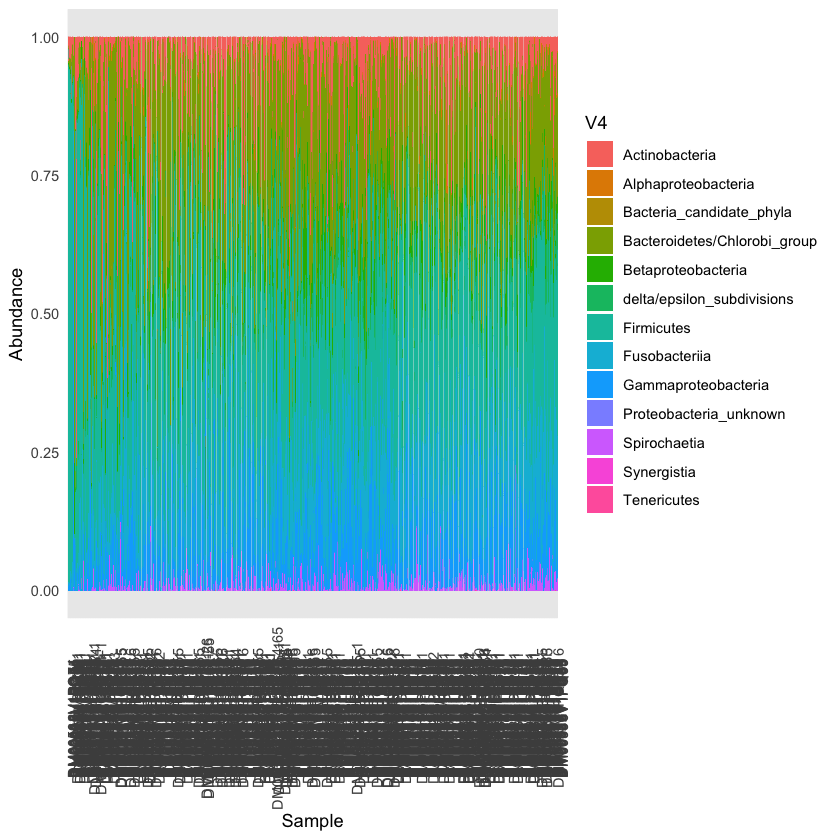

pdf 
  2

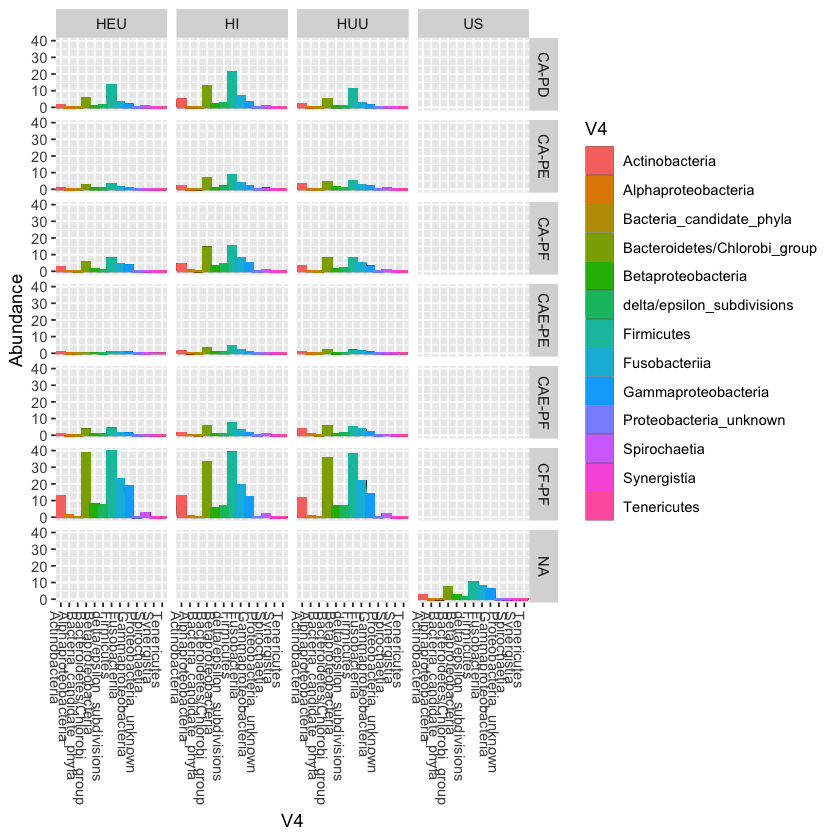

In [12]:
system("mkdir img")
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot by sample
taxbarsamp <- ggplot(data, aes(x=Sample, y=Abundance, fill=V4)) + geom_bar(aes(), stat="identity", position="stack") + theme_minimal() + theme(axis.text.x = element_text(angle = 90))
taxbarsamp
pdf("img/taxonomy_barchart.pdf")
taxbarsamp
dev.off()
# phyloseq group by hiv status and aliquot type
taxbargrp <- plot_bar(rel.abund, "V4", fill="V4", facet_grid=aliquot_type~study_group) + geom_bar(aes(color=V4, fill=V4), stat="identity", position="stack")
taxbargrp
pdf("img/tax_bar.aliquot_by_sample.pdf")
taxbargrp
dev.off()

### 4. Stacked barchart grouped by study group and aliquot type (phylum level)

`summarise()` has grouped output by 'study_group', 'aliquot_type'. You can override using the `.groups`
argument.


pdf 
  2

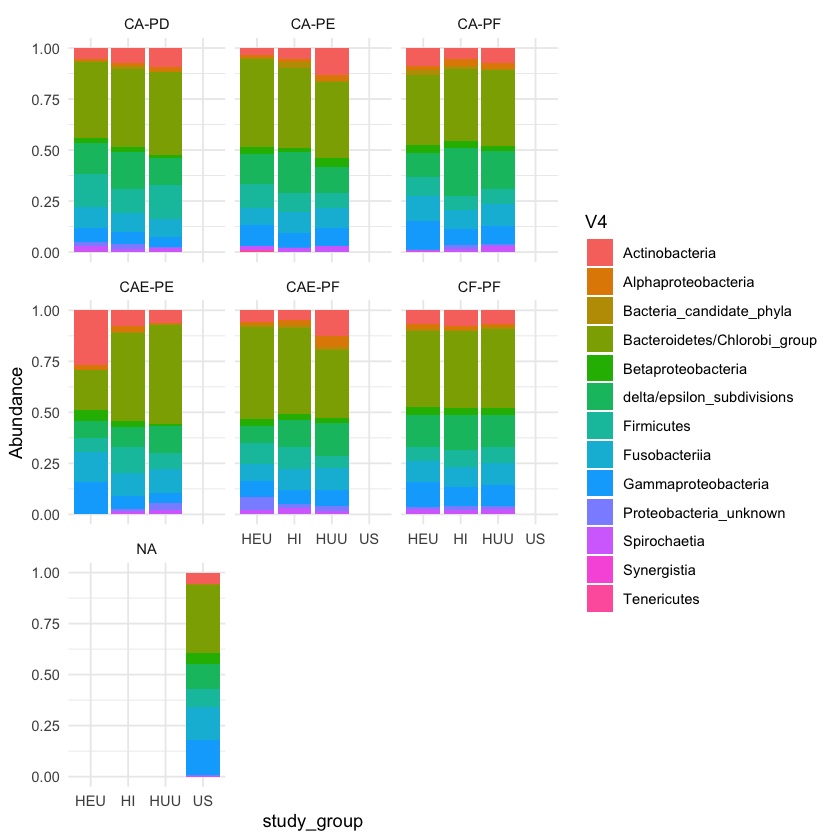

In [13]:
grouped <- data %>% group_by(study_group, aliquot_type, V4) %>% summarize(Abundance = mean(Abundance))
taxbarphy <- ggplot(grouped, aes(fill=V4, y=Abundance, x=study_group)) + geom_bar(position="fill", stat="identity") + facet_wrap(~aliquot_type) + theme_minimal()
taxbarphy
pdf("img/bar.study_group.phyla.pdf")
taxbarphy
dev.off()

### 5. Stacked barchart at family level (only above 20% frequency)

`summarise()` has grouped output by 'study_group', 'aliquot_type'. You can override using the `.groups`
argument.


pdf 
  2

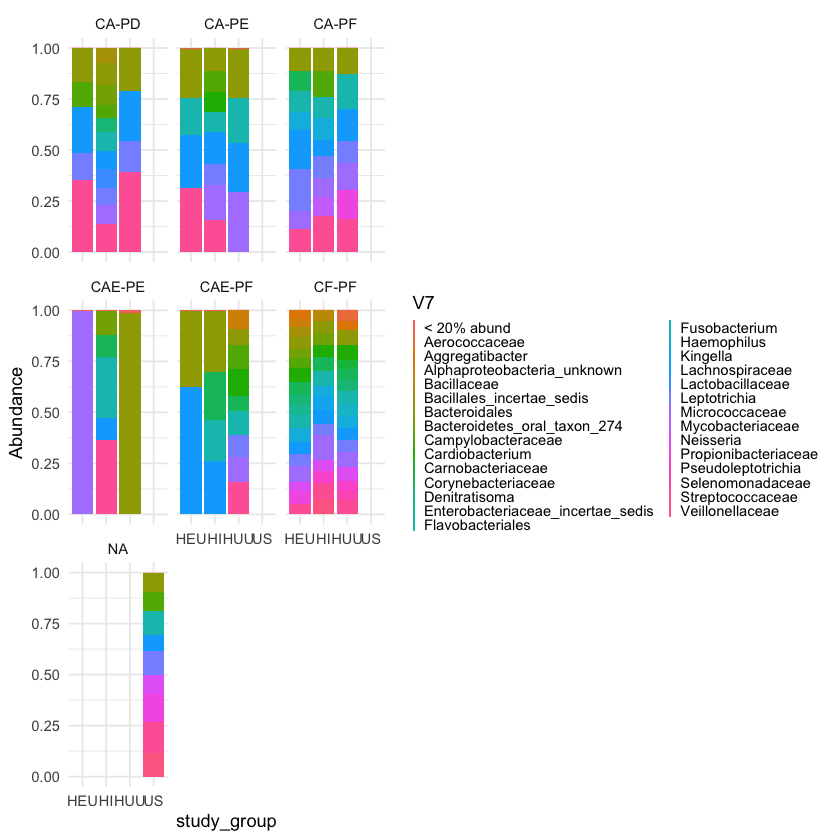

In [14]:
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[8]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V7 <- as.character(data$V7) # convert to character
data$V7[data$Abundance < 0.2] <- "< 20% abund" # rename low freq phyla
grouped <- data %>% group_by(study_group, aliquot_type, V7) %>% summarize(Abundance = mean(Abundance))
famtaxbar <- ggplot(grouped, aes(fill=V7, y=Abundance, x=study_group)) + geom_bar(position="fill", stat="identity") + facet_wrap(~aliquot_type) + theme_minimal() + theme(legend.key.size=unit(0.000001, "cm"))
famtaxbar
pdf("img/bar.study_group.L7.pdf")
famtaxbar
dev.off()

# PhILR transformation

In [15]:
philr.dat <- transform_sample_counts(ps.dat, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
is.rooted(phy_tree(philr.dat)) # check that tree is rooted
# [1] TRUE
is.binary(phy_tree(philr.dat)) #check that multichotomies are resolved in tree
# [1] TRUE
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")

[1] TRUE

[1] TRUE

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...



# Beta diversity

### 1. Get distance matrix from PhILR transformed data

In [16]:
philr.dist <- dist(philr.t, method="euclidean") 

### 2. PCA plots

pdf 
  2

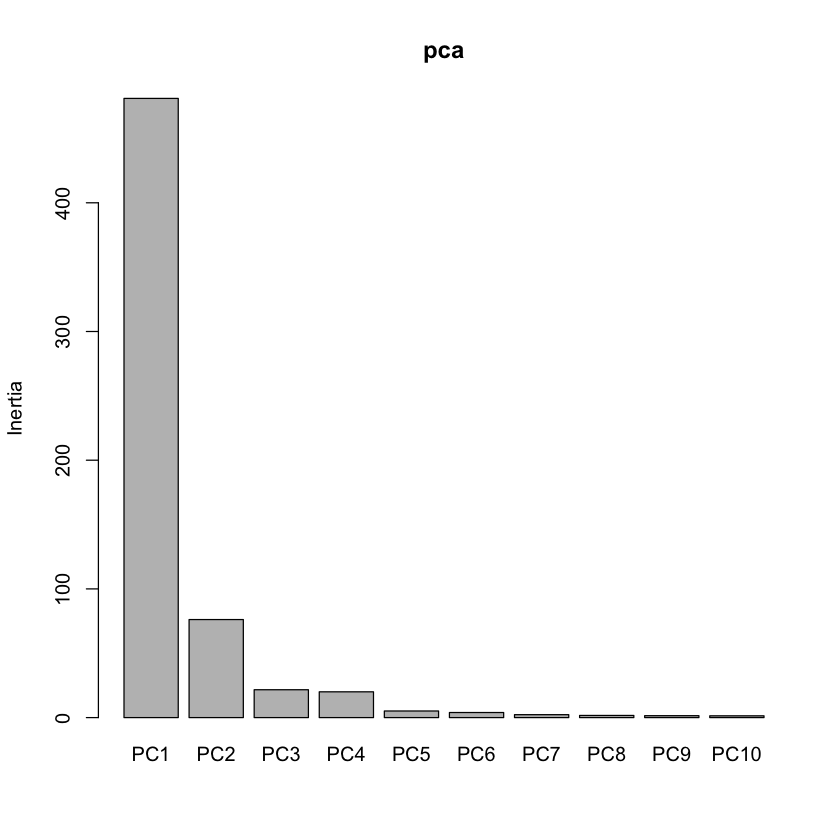

pdf 
  2

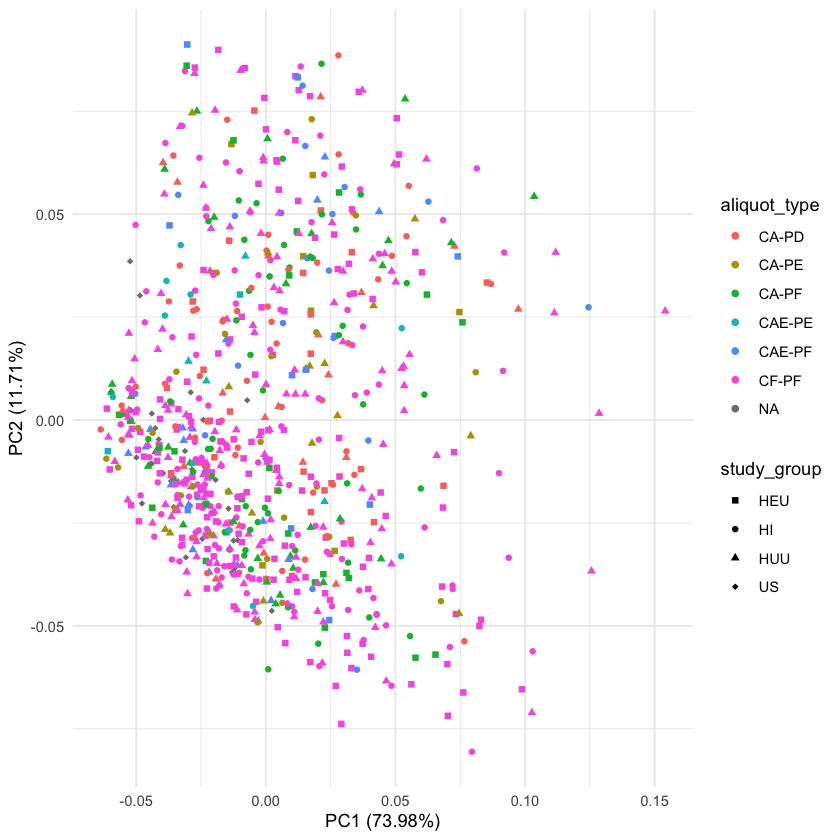

pdf 
  2

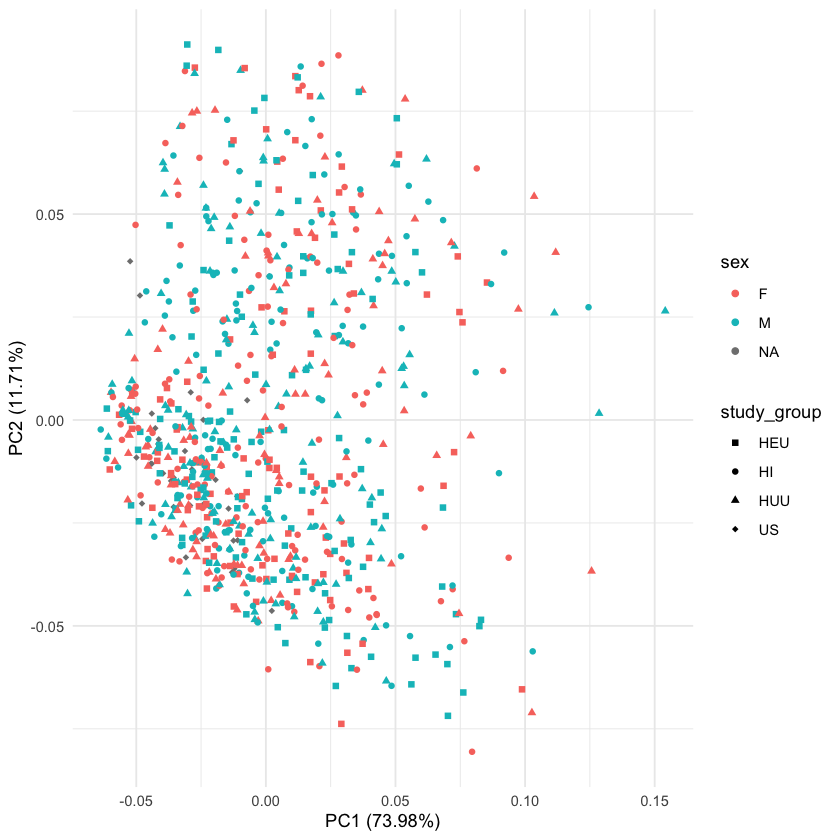

In [32]:
# scree plot
pca <- prcomp(as.matrix(philr.dist))
screeplot(pca)
pdf("img/pca_screeplot.pdf")
screeplot(pca)
dev.off()
# colored by aliquot type, shape by study group
autoplot(pca, data=sample_data(philr.dat), colour="aliquot_type", shape="study_group") + theme_minimal() + scale_shape_manual(values=c(15, 16, 17, 18))
pdf("img/pca.aliquot_type.pdf")
autoplot(pca, data=sample_data(philr.dat), colour="aliquot_type", shape="study_group") + theme_minimal() + scale_shape_manual(values=c(15, 16, 17, 18))
dev.off()
# study group, sex
autoplot(pca, data=sample_data(philr.dat), colour="sex", shape="study_group") + theme_minimal() + scale_shape_manual(values=c(15, 16, 17, 18))
pdf("img/pca.sex.pdf")
autoplot(pca, data=sample_data(philr.dat), colour="sex", shape="study_group") + theme_minimal() + scale_shape_manual(values=c(15, 16, 17, 18))
dev.off()

### 3. PERMANOVA

Remove US kids from dataframe and regenerate philr dist `

In [27]:
philr.dat.noUS <- subset_samples(philr.dat, study_group != "US")
phy_tree(philr.dat.noUS) <- makeNodeLabel(phy_tree(philr.dat.noUS), method="number", prefix="n")
asv.table <- otu_table(philr.dat.noUS)
tree <- phy_tree(philr.dat.noUS)
metadata <- as(sample_data(philr.dat.noUS), "data.frame")
tax <- tax_table(philr.dat.noUS)
philr.t.noUS <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
# now generate distance matrix
philr.dist.noUS <- dist(philr.t.noUS, method="euclidean") 

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...



Comparing study group, aliquot type, sex, and age

In [28]:
adonis(philr.dist.noUS ~ study_group * aliquot_type * sex * age_y, data=metadata)


Call:
adonis(formula = philr.dist.noUS ~ study_group * aliquot_type *      sex * age_y, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                    Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
study_group                          2      91.0  45.493  2.5071 0.00644  0.001
aliquot_type                         5     224.0  44.807  2.4693 0.01585  0.001
sex                                  1      28.9  28.885  1.5918 0.00204  0.017
age_y                                1     117.0 116.965  6.4458 0.00828  0.001
study_group:aliquot_type            10     269.2  26.923  1.4837 0.01905  0.001
study_group:sex                      2      61.4  30.677  1.6906 0.00434  0.002
aliquot_type:sex                     5     124.1  24.810  1.3673 0.00878  0.004
study_group:age_y                    2      63.7  31.836  1.7545 0.00451  0.001
aliquot_type:age_y                   5      86.0  17.204  0.9481 0.00609  0.642
sex

### 4. Pairwise tests

Matrix for neighbor joining trees

In [33]:
# no us kids phyloseq object
ps.dat.noUS <- subset_samples(ps.dat, study_group != "US")
t <- pairwise.adonis(otu_table(ps.dat.noUS), sample_data(ps.dat.noUS)$study_group)
# t
mat <- matrix(0, length(levels(as.factor(sample_data(ps.dat.noUS)$study_group))), length(levels(as.factor(sample_data(ps.dat.noUS)$study_group))))
mat[lower.tri(mat, diag=F)] <- t$F.Model
# mat
write.matrix(mat, "study_group_distance.formeta.meg", sep=" ")

t <- pairwise.adonis(otu_table(ps.dat.noUS), sample_data(ps.dat.noUS)$aliquot_type)
# t
mat <- matrix(0, length(levels(as.factor(sample_data(ps.dat.noUS)$aliquot_type))), length(levels(as.factor(sample_data(ps.dat.noUS)$aliquot_type))))
mat[lower.tri(mat, diag=F)] <- t$F.Model
# mat
write.matrix(mat, "aliquot_type_distance.formeta.meg", sep=" ")

# make new metadata category to do HIV status + tooth type
sample_data(ps.dat.noUS)$aliquot_study <- paste(sample_data(ps.dat.noUS)$study_group, sample_data(ps.dat.noUS)$aliquot_type, sep=".")
t <- pairwise.adonis(otu_table(ps.dat.noUS), sample_data(ps.dat.noUS)$aliquot_study)
# t
mat <- matrix(0, length(levels(as.factor(sample_data(ps.dat.noUS)$aliquot_study))), length(levels(as.factor(sample_data(ps.dat.noUS)$aliquot_study))))
mat[lower.tri(mat, diag=F)] <- t$F.Model
# mat
write.matrix(mat, "aliquot_type_study_group_distance.formeta.meg", sep=" ")

Set of permutations < 'minperm'. Generating entire set.



### 5. Beta dispersion tests

[1] "aliquot type:"



	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist.noUS, group =
phyloseq::sample_data(philr.dat.noUS)$aliquot_type)

No. of Positive Eigenvalues: 747
No. of Negative Eigenvalues: 0

Average distance to median:
 CA-PD  CA-PE  CA-PF CAE-PE CAE-PF  CF-PF 
 4.139  4.224  4.248  3.566  4.133  4.200 

Eigenvalues for PCoA axes:
(Showing 8 of 747 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
1713.6  864.9  834.4  422.2  314.7  242.1  211.1  198.0 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups      5   7.86  1.5728 1.3698    999  0.238
Residuals 742 851.96  1.1482                     

[1] "study group:"



	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist.noUS, group =
phyloseq::sample_data(philr.dat.noUS)$study_group)

No. of Positive Eigenvalues: 747
No. of Negative Eigenvalues: 0

Average distance to median:
  HEU    HI   HUU 
4.278 4.188 4.143 

Eigenvalues for PCoA axes:
(Showing 8 of 747 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
1713.6  864.9  834.4  422.2  314.7  242.1  211.1  198.0 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups      2   2.15  1.0727 0.9248    999  0.371
Residuals 745 864.14  1.1599                     

[1] "sex:"



	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist.noUS, group =
phyloseq::sample_data(philr.dat.noUS)$sex)

No. of Positive Eigenvalues: 747
No. of Negative Eigenvalues: 0

Average distance to median:
    F     M 
4.196 4.221 

Eigenvalues for PCoA axes:
(Showing 8 of 747 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
1713.6  864.9  834.4  422.2  314.7  242.1  211.1  198.0 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups      1   0.12 0.12044 0.1031    999  0.745
Residuals 746 871.34 1.16801                     

[1] "age:"



	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist.noUS, group =
phyloseq::sample_data(philr.dat.noUS)$age_y)

No. of Positive Eigenvalues: 747
No. of Negative Eigenvalues: 0

Average distance to median:
    3     4     5     6     7     8     9    10 
3.501 3.846 3.720 4.188 4.190 4.446 4.446 4.296 

Eigenvalues for PCoA axes:
(Showing 8 of 747 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
1713.6  864.9  834.4  422.2  314.7  242.1  211.1  198.0 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)    
Groups      7  59.95  8.5642 7.9199    999  0.001 ***
Residuals 740 800.20  1.0814                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

ERROR: Error in eval(expr, envir, enclos): object 'betadisp.age' not found


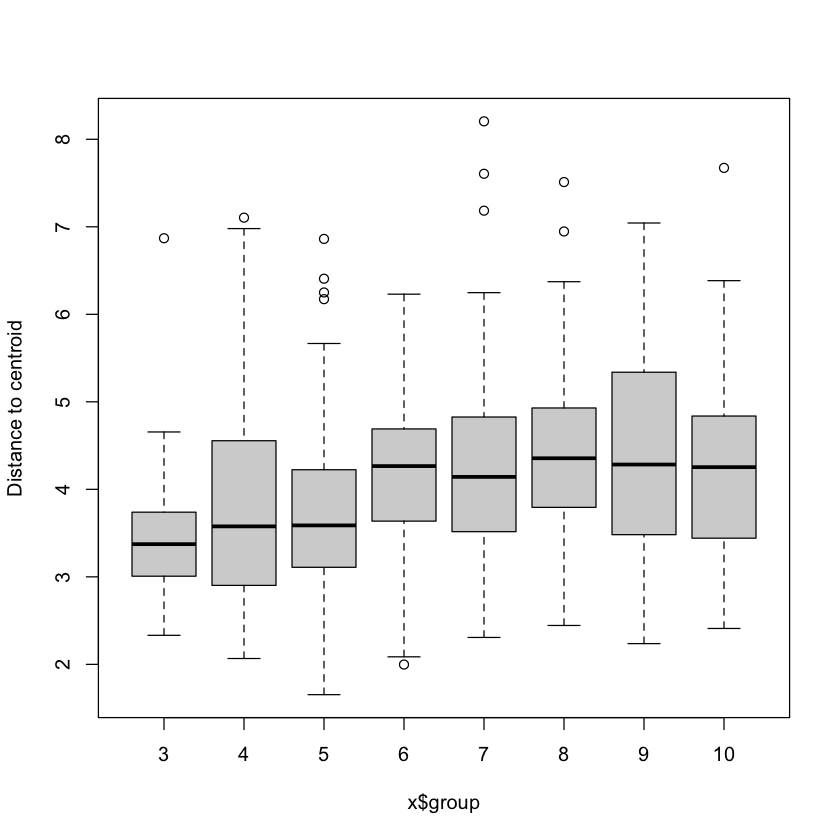

In [34]:
dispr <- vegan::betadisper(philr.dist.noUS, phyloseq::sample_data(philr.dat.noUS)$aliquot_type)
print("aliquot type:")
dispr
permutest(dispr)
dispr <- vegan::betadisper(philr.dist.noUS, phyloseq::sample_data(philr.dat.noUS)$study_group)
print("study group:")
dispr
permutest(dispr)
dispr <- vegan::betadisper(philr.dist.noUS, phyloseq::sample_data(philr.dat.noUS)$sex)
print("sex:")
dispr
permutest(dispr)
dispr <- vegan::betadisper(philr.dist.noUS, phyloseq::sample_data(philr.dat.noUS)$age_y)
print("age:")
dispr
permutest(dispr)
betadis.age <- boxplot(dispr)
betadisp.age
pdf("img/betadispr.age.pdf")
betadisp.age
dev.off()
betadisp.ord <- plot(dispr)
betadisp.ord
pdf("img/betadispr.age.ord.pdf")
betadisp.ord
dev.off()

What if we looked at different tooth types by HIV status?


	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist.noUS, group =
phyloseq::sample_data(philr.dat.noUS)$study_aliquot)

No. of Positive Eigenvalues: 747
No. of Negative Eigenvalues: 0

Average distance to median:
 HEU.CA-PD   HI.CA-PD  HUU.CA-PD  HEU.CA-PE   HI.CA-PE  HUU.CA-PE  HEU.CA-PF 
     4.215      4.022      4.051      4.190      3.905      4.296      4.206 
  HI.CA-PF  HUU.CA-PF HEU.CAE-PE  HI.CAE-PE HUU.CAE-PE HEU.CAE-PF  HI.CAE-PF 
     4.188      4.166      2.477      3.509      3.391      4.089      4.235 
HUU.CAE-PF  HEU.CF-PF   HI.CF-PF  HUU.CF-PF 
     3.492      4.219      4.186      4.147 

Eigenvalues for PCoA axes:
(Showing 8 of 747 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
1713.6  864.9  834.4  422.2  314.7  242.1  211.1  198.0 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups     17  25.96  1.5269 1.3584    999  0.136
Residuals 730 820.56  1.1241                     

pdf 
  2

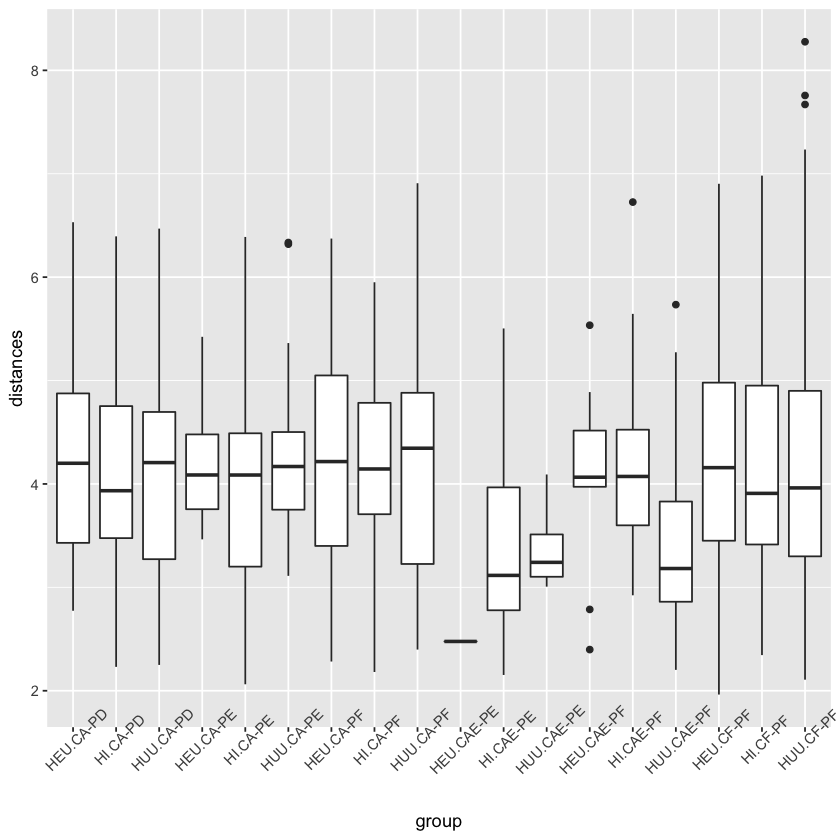

In [35]:
phyloseq::sample_data(philr.dat.noUS)$study_aliquot <- with(phyloseq::sample_data(philr.dat.noUS), interaction(phyloseq::sample_data(philr.dat.noUS)$study_group, phyloseq::sample_data(philr.dat.noUS)$aliquot_type))
dispr <- vegan::betadisper(philr.dist.noUS, phyloseq::sample_data(philr.dat.noUS)$study_aliquot)
dispr
permutest(dispr)
df <- data.frame(group=dispr$group, distances=dispr$distances)
pdf("img/betadispr.study_aliquot.pdf")
ggplot(df, aes(group, distances)) + geom_boxplot() + theme(axis.text.x=element_text(angle=45))
dev.off()
ggplot(df, aes(group, distances)) + geom_boxplot() + theme(axis.text.x=element_text(angle=45))

Distance based redundancy analysis

pdf 
  2

pdf 
  2

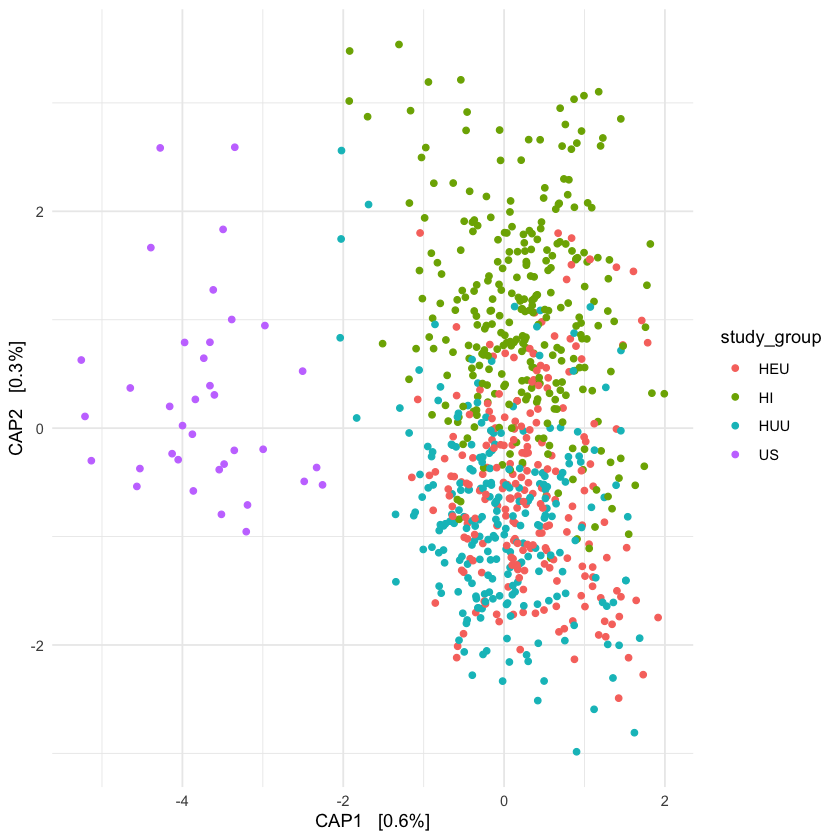

pdf 
  2

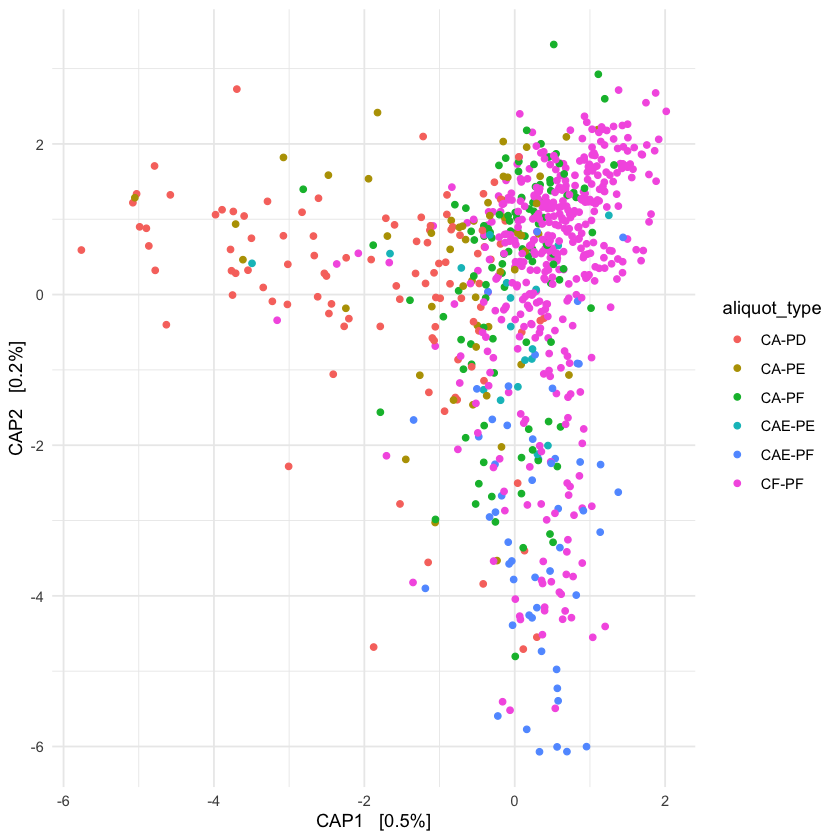

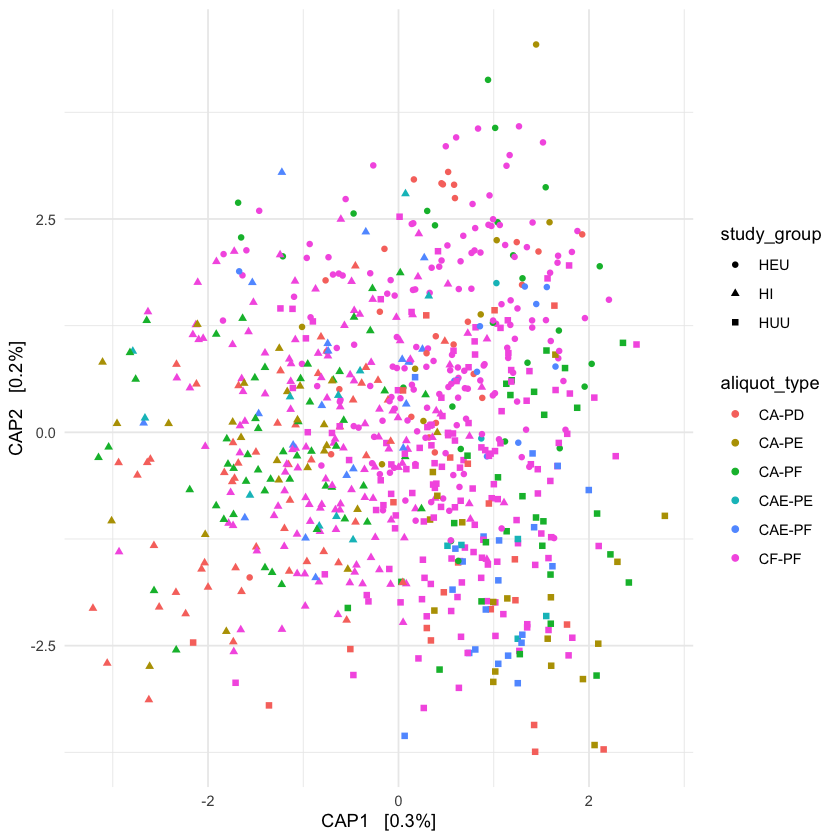

In [36]:
ordcap <- ordinate(ps.dat, "CAP", "bray", ~study_group)
pdf("img/capscale_plt.study_group.pdf") 
plot_ordination(ps.dat, ordcap, "samples", color="study_group") + theme_minimal()
dev.off()
plot_ordination(ps.dat, ordcap, "samples", color="study_group") + theme_minimal()

ordcap <- ordinate(ps.dat.noUS, "CAP", "bray", ~aliquot_type)
pdf("img/capscale_plt.aliquot_type.pdf")
plot_ordination(ps.dat.noUS, ordcap, "samples", color="aliquot_type") + theme_minimal()
dev.off()
plot_ordination(ps.dat.noUS, ordcap, "samples", color="aliquot_type") + theme_minimal()

ordcap <- ordinate(ps.dat.noUS, "CAP", "bray", aliquot_type~study_group)
pdf("img/capscale_plt.aliquot_type.study_group.pdf")
plot_ordination(ps.dat, ordcap, "samples", color="aliquot_type", shape="study_group") + theme_minimal()
dev.off()
plot_ordination(ps.dat, ordcap, "samples", color="aliquot_type", shape="study_group") + theme_minimal()

# Alpha diversity

pdf 
  2

pdf 
  2

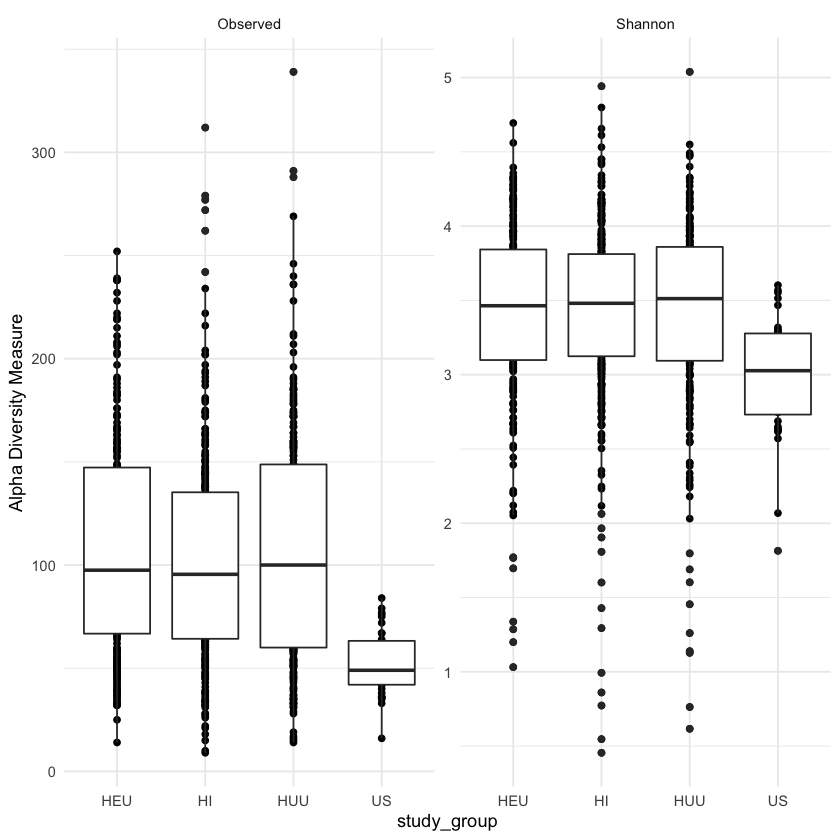

pdf 
  2

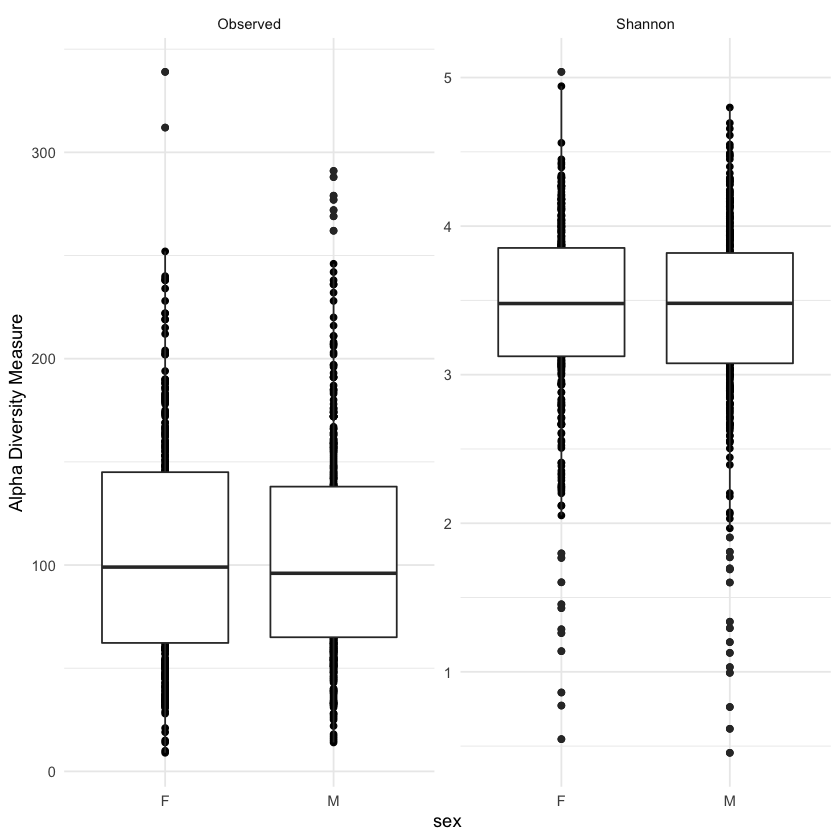

pdf 
  2

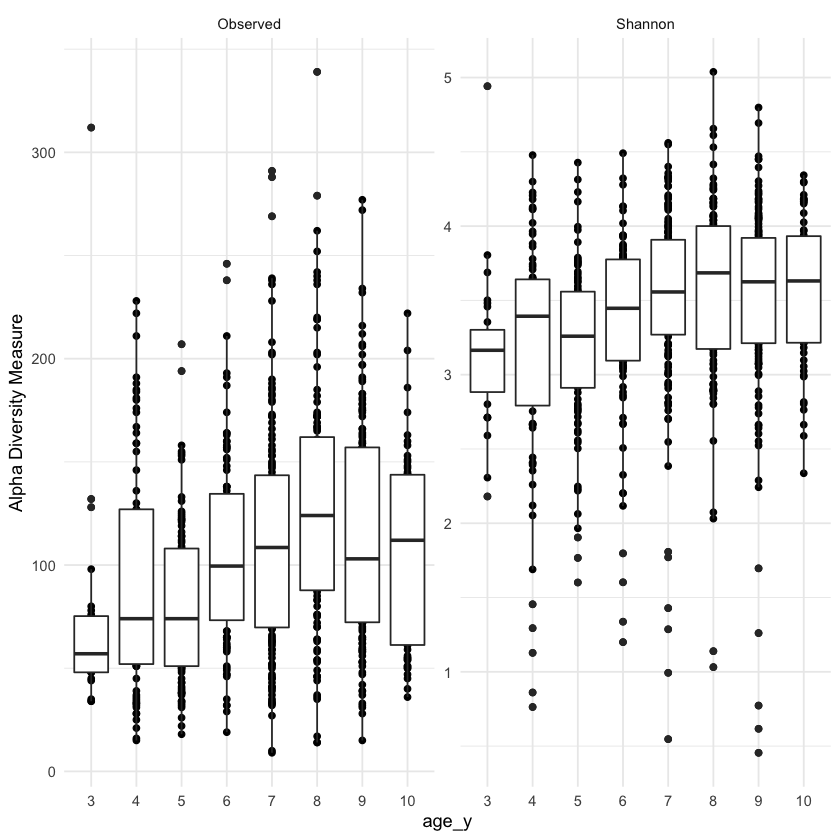

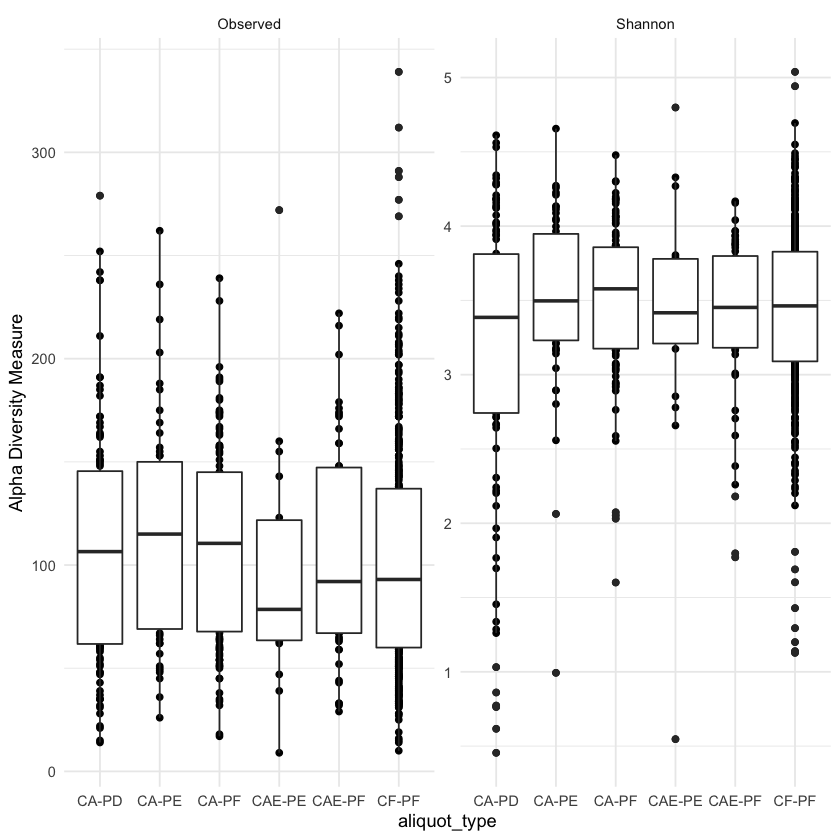

In [37]:
# study group
pdf("img/adiv.study_group.pdf")
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="study_group") + geom_boxplot() + theme_minimal() 
dev.off()
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="study_group") + geom_boxplot() + theme_minimal() 

# sex
pdf("img/adiv.sex.pdf")
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="sex") + geom_boxplot() + theme_minimal()
dev.off()
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="sex") + geom_boxplot() + theme_minimal()

# age
sample_data(ps.dat.noUS)$age_y <- as.factor(sample_data(ps.dat.noUS)$age_y)
pdf("img/adiv.age_y.pdf")
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="age_y") + geom_boxplot() + theme_minimal()
dev.off()
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="age_y") + geom_boxplot() + theme_minimal()

# aliqout type 
pdf("img/adiv.aliqout_type.pdf")
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="aliquot_type") + geom_boxplot() + theme_minimal()
dev.off()
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="aliquot_type") + geom_boxplot() + theme_minimal()

# Shared features

pdf 
  2

pdf 
  2

pdf 
  2

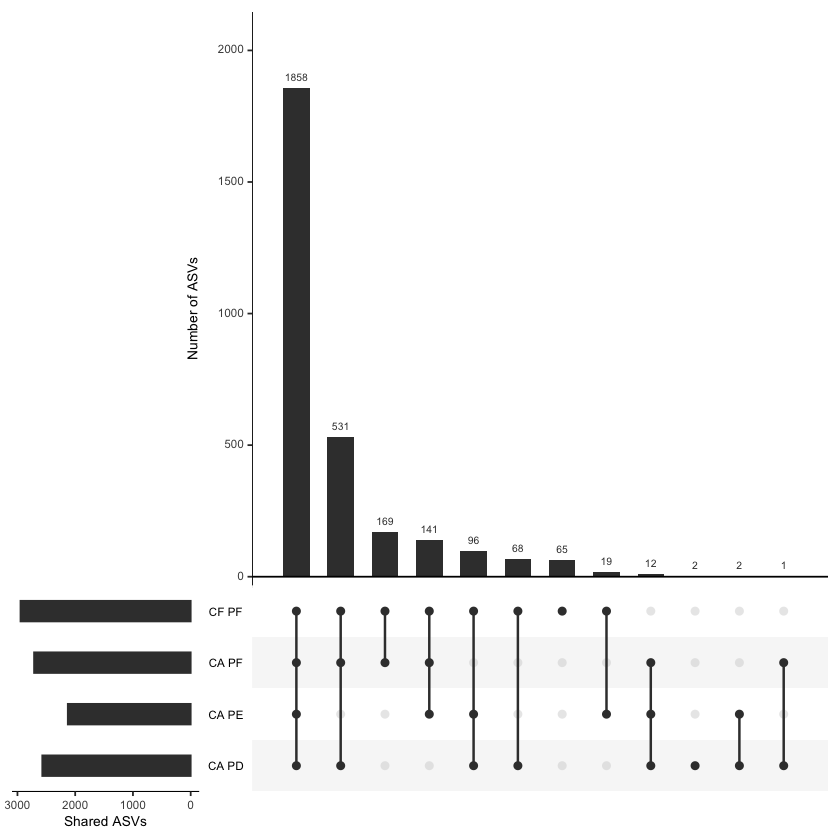

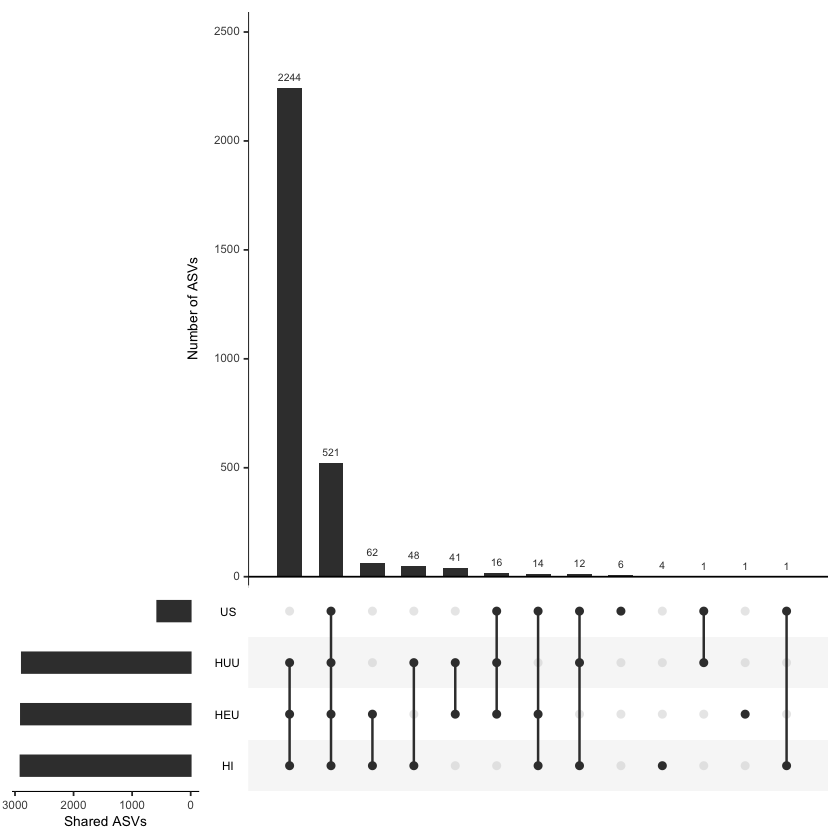

In [39]:
merged <- merge(otu_table(ps.dat), sample_data(ps.dat), by="row.names")
n <- ncol(otu_table(ps.dat)) + 1
# by sex
agg <- aggregate(merged[,2:n], by=list(merged$sex), FUN=sum) 
#remove columns with only zeros
agg <- agg[,colSums(agg !=0) > 0]
rownames(agg) <- agg$Group.1
#convert to presence absence table 
agg[agg>1] <- 1
agg <- data.frame(t(agg[,-1]))
pdf("img/upset.sex.pdf")
upset(agg, order.by="freq", mainbar.y.label="Number of ASVs", sets.x.label="Shared ASVs")
dev.off()

# by aliquot type
agg <- aggregate(merged[,2:n], by=list(merged$aliquot_type), FUN=sum) 
#remove columns with only zeros
agg <- agg[,colSums(agg !=0) > 0]
rownames(agg) <- agg$Group.1
#convert to presence absence table 
agg[agg>1] <- 1
agg <- data.frame(t(agg[,-1]))
#reorder
agg <- agg[,c("CA.PD", "CA.PE", "CA.PF", "CAE.PE", "CAE.PF", "CF.PF")]
pdf("img/upset.aliquot_type.pdf")
upset(agg, keep.order=T, sets=c("CA.PD", "CA.PE", "CA.PF", "CF.PF"), order.by="freq",mainbar.y.label="Number of ASVs", sets.x.label="Shared ASVs")
dev.off()
upset(agg, keep.order=T, sets=c("CA.PD", "CA.PE", "CA.PF", "CF.PF"), order.by="freq",mainbar.y.label="Number of ASVs", sets.x.label="Shared ASVs")

# by study_group
agg <- aggregate(merged[,2:n], by=list(merged$study_group), FUN=sum) 
#remove columns with only zeros
agg <- agg[,colSums(agg !=0) > 0]
rownames(agg) <- agg$Group.1
#convert to presence absence table 
agg[agg>1] <- 1
agg <- data.frame(t(agg[,-1]))
pdf("img/upset.study_group.pdf")
upset(agg, order.by="freq", mainbar.y.label="Number of ASVs", sets.x.label="Shared ASVs")
dev.off()
upset(agg, order.by="freq", mainbar.y.label="Number of ASVs", sets.x.label="Shared ASVs")

# Random forest classification

In [43]:
# format data
asv_tab <- as(otu_table(ps.dat.noUS), "matrix")
metadata <- as(sample_data(ps.dat.noUS), "data.frame")

metadata$study_group <- factor(metadata$study_group)
# get relative abudance
asv_tab_norm <- sweep(asv_tab, 2, colSums(asv_tab), '/')*100
asv_tab_scale <- scale(asv_tab_norm, center=T, scale=T)
asv_tab_var <- data.frame(asv_tab_scale)
# remove nas
asv_tab_var <- asv_tab_var[, colSums(is.na(asv_tab_var)) == 0]
set.seed(151)

# by study group
asv_tab_var$var <- metadata[rownames(asv_tab_var), "study_group"]
rf.study_group <- randomForest(x=asv_tab_var[,1:(ncol(asv_tab_var)-1)], y=asv_tab_var$var, ntree=10000, importance=T, proximity=T)
rf.study_group

# plot important ASVs
pdf("img/rf.study_group.importance.pdf")
varImpPlot(rf.study_group)
dev.off()
varImpPlot(rf.study_group)

# by aliquot type
# since there is a major sample number descrepancy, randomly sample to 100 samples in CA-PD, CA-PF, CF-PF (all others less than 100 samples) 
temp <- filter(asv_tab_var, var == "CF-PF" | var == "CA-PF" | var == "CA-PF" | var == "CA-PD")
temp$var <- droplevels(temp$var)
asv_tab_var.filt <- as.data.frame(temp %>% group_by(var) %>% sample_n(100))

rf.filt.aliquot_type <- randomForest(x=asv_tab_var.filt[,1:(ncol(asv_tab_var.filt)-1)], y=asv_tab_var.filt$var, ntree=10000, importance=T, proximity=T)
rf.filt.aliquot_type
# plot important ASVs
pdf("img/rf.filt.aliquot_type.importance.pdf")
varImpPlot(rf.filt.aliquot_type)
dev.off()
varImpPlot(rf.filt.aliquot_type)

# how do different tooth types look between HIV status states?
# first need to merge study_group and aliquot_type
metadata$study_aliquot <- with(metadata, interaction(study_group, aliquot_type))

# filtered to only include DOMHaIN samples, top tooth types
temp <- filter(asv_tab_var, var == "HEU.CF-PF" | var == "HI.CF-PF" | var == "HUU.CF-PF")
temp$var <- droplevels(temp$var)
asv_tab_var.filt <- as.data.frame(temp %>% group_by(var) %>% sample_n(100))

rf.filt.sample_aliquot <- randomForest(x=asv_tab_var.filt[,1:(ncol(asv_tab_var.filt)-1)], y=asv_tab_var.filt$var, ntree=10000, importance=T, proximity=T)
rf.filt.sample_aliquot
# CA-PD
temp <- filter(asv_tab_var, var == "HEU.CA-PD" | var == "HI.CA-PD" | var == "HUU.CA-PD")
temp$var <- as.factor(temp$var)
temp$var <- droplevels(temp$var)
asv_tab_var.filt <- as.data.frame(temp %>% group_by(var) %>% sample_n(20))
rf.filt.sample_aliquot <- randomForest(x=asv_tab_var.filt[,1:(ncol(asv_tab_var.filt)-1)], y=asv_tab_var.filt$var, ntree=10000, importance=T, proximity=T)
rf.filt.sample_aliquot

# Core taxa

In [ ]:
# normalize
ps.dat.core <- microbiome::transform(ps.dat.noUS, "compositional")
# overall top taxa
paste("top 10 taxa in full dataset: ", head(prevalence(ps.dat.core, detection = 1/100, sort = T), 10))
# core taxa in HI samples
paste("top 10 taxa in HI samples: ", head(prevalence(subset_samples(ps.dat.core, study_group == "HI"), detection = 1/100, sort = T), 10))
# core taxa in HEU samples
paste("top 10 taxa in HEU samples: ", head(prevalence(subset_samples(ps.dat.core, study_group == "HEU"), detection = 1/100, sort = T), 10))
# core taxa in HUU samples
paste("top 10 taxa in HUU samples: ", head(prevalence(subset_samples(ps.dat.core, study_group == "HUU"), detection = 1/100, sort = T), 10))
# what about differences in tooth type in HI individuals?
paste("in HI-CF-PF samples: ", head(prevalence(subset_samples(ps.dat.core, study_group == "HI" & aliquot_type == "CF-PF"), detection = 1/100, sort = T), 10))
paste("in HI CA-PD samples: ", head(prevalence(subset_samples(ps.dat.core, study_group == "HI" & aliquot_type == "CA-PD"), detection = 1/100, sort = T), 10))
paste("in HUU CF-PF samples: ", head(prevalence(subset_samples(ps.dat.core, study_group == "HUU" & aliquot_type == "CF-PF"), detection = 1/100, sort = T), 10))
paste("in HUU CA-PD samples: ", head(prevalence(subset_samples(ps.dat.core, study_group == "HUU" & aliquot_type == "CA-PD"), detection = 1/100, sort = T), 10))
paste("in HEU CF-PF samples: ", head(prevalence(subset_samples(ps.dat.core, study_group == "HEU" & aliquot_type == "CF-PF"), detection = 1/100, sort = T), 10))
paste("in HEU CA-PD samples: ", head(prevalence(subset_samples(ps.dat.core, study_group == "HEU" & aliquot_type == "CA-PD"), detection = 1/100, sort = T), 10))